#    Cognitive Model - rule-based simulation

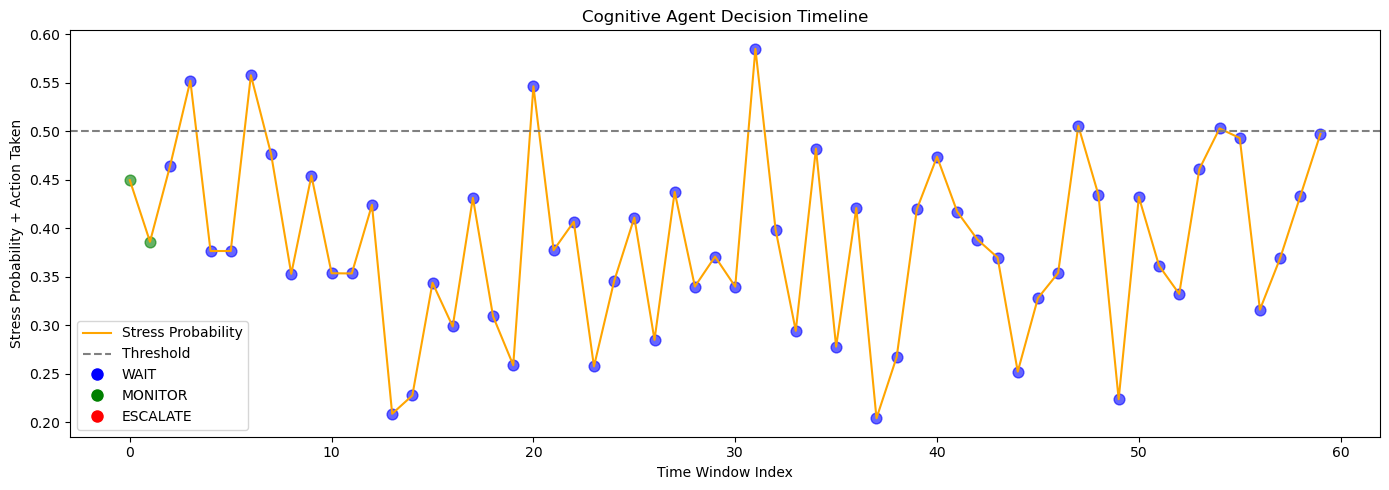

,TimeWindow,StressProb,StressPredicted,Memory,Noise,Confidence,UrgencyScore,ActionTaken
0,0,0.449671,0,4.03,0.235,0.765,-0.235,MONITOR
1,1,0.386174,0,4.03,0.337,0.663,-0.337,MONITOR
2,2,0.464769,0,4.03,0.453,0.547,-0.453,WAIT
3,3,0.552303,1,4.03,0.583,0.417,-0.167,WAIT
4,4,0.376585,0,4.03,0.648,0.352,-0.648,WAIT
5,5,0.376586,0,4.03,0.706,0.294,-0.706,WAIT
6,6,0.557921,1,4.03,0.813,0.187,-0.626,WAIT
7,7,0.476743,0,4.03,0.885,0.115,-0.885,WAIT
8,8,0.353053,0,4.03,0.912,0.088,-0.912,WAIT
9,9,0.454256,0,4.03,0.967,0.033,-0.967,WAIT


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Simulated Stress Timeline (probability & decision)
np.random.seed(42)
n_windows = 60
probability = np.clip(np.random.normal(0.4, 0.1, n_windows), 0, 1)
predicted_stress = (probability > 0.5).astype(int)

# Parameters for simulation
decay = 0.9              # Cognitive memory decay (affects recent experience weighting)
base_noise = 0.1         # Default noise level for decisions
accuracy_threshold = 0.6 # Confidence needed to act
latency_penalty = 1.0    # Cost of late response under high stress

# Decision-making simulation
actions, decision_noise, decision_conf, urgency_scores = [], [], [], []

stress_level = 0
urgency_state = 0
stress_memory = 0.0

for t in range(n_windows):
    p = probability[t]
    is_stress = predicted_stress[t]

    # Decay past stress memory, integrate current
    stress_memory = decay * stress_memory + p

    # Compute noise (higher under stress)
    noise = base_noise + (0.3 * stress_memory)
    decision_noise.append(noise)

    # Decision confidence drops with noise
    confidence = 1.0 - noise
    decision_conf.append(confidence)

    # Urgency grows if consecutive stress
    if is_stress:
        urgency_state += 1
    else:
        urgency_state = max(0, urgency_state - 1)

    # Simple decision rule
    if confidence > accuracy_threshold:
        action = "ESCALATE" if urgency_state >= 2 else "MONITOR"
    else:
        action = "WAIT"

    # Final urgency score
    urgency = confidence * urgency_state - noise * latency_penalty
    urgency_scores.append(urgency)
    actions.append(action)

# Summary dataframe
agent_df = pd.DataFrame({
    "TimeWindow": range(n_windows),
    "StressProb": probability,
    "StressPredicted": predicted_stress,
    "Memory": np.round(stress_memory, 2),
    "Noise": np.round(decision_noise, 3),
    "Confidence": np.round(decision_conf, 3),
    "UrgencyScore": np.round(urgency_scores, 3),
    "ActionTaken": actions
})

# Plot action timeline
plt.figure(figsize=(14, 5))
plt.plot(probability, label='Stress Probability', color='orange')
plt.axhline(0.5, linestyle='--', color='gray', label='Threshold')

colors = {"ESCALATE": 'red', "MONITOR": 'green', "WAIT": 'blue'}
for t, act in enumerate(actions):
    plt.scatter(t, probability[t], color=colors[act], s=60, marker='o', alpha=0.6)



# Existing plot lines
plt.title("Cognitive Agent Decision Timeline")
plt.xlabel("Time Window Index")
plt.ylabel("Stress Probability + Action Taken")

# ✅ Add manual legend for actions
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='orange', label='Stress Probability'),
    Line2D([0], [0], linestyle='--', color='gray', label='Threshold'),
    Line2D([0], [0], marker='o', color='w', label='WAIT', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='MONITOR', markerfacecolor='green', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='ESCALATE', markerfacecolor='red', markersize=10)
]
plt.legend(handles=legend_elements)
plt.tight_layout()
plt.savefig("c1.png", dpi=300, bbox_inches='tight')
plt.show()



# Return summary
agent_df.head(10)


# SpeedyIBL Agent - cognitive agent

In [ ]:
# pip install pyibl

In [12]:
pip install -U speedyibl

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [7]:
from speedyibl import Agent 

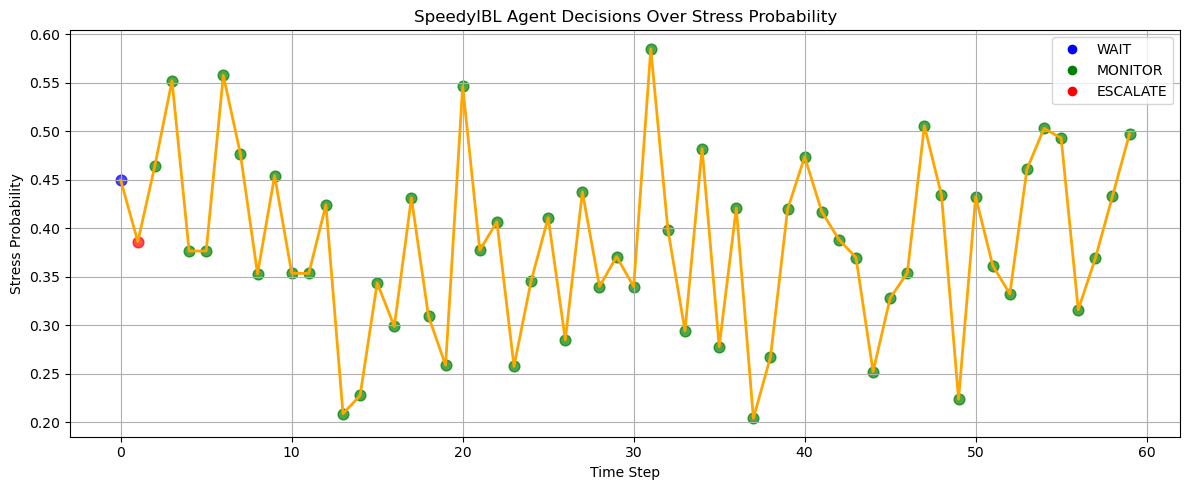

(Action
 MONITOR     58
 WAIT         1
 ESCALATE     1
 Name: count, dtype: int64,
 0.1866666666666666)

In [13]:
# Re-import packages after kernel reset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from speedyibl import Agent

# 1️⃣ Setup
np.random.seed(42)
n_trials = 60
stress_probs = np.clip(np.random.normal(0.4, 0.1, n_trials), 0, 1)
actions = ['WAIT', 'MONITOR', 'ESCALATE']

# 2️⃣ Initialize SpeedyIBL agent
agent = Agent(default_utility=0.0)

# 3️⃣ Prepopulate with dummy trials to introduce all actions
for act in actions:
    agent.choose([act])  # simulate decision opportunity
    agent.respond(0.0)   # no reward for now

# 4️⃣ Define reward function based on stress probability
def reward_function(prob, action):
    if prob > 0.55 and action == 'ESCALATE':
        return 1.0
    elif prob > 0.6 and action == 'WAIT':
        return -1.0
    elif prob < 0.4 and action == 'WAIT':
        return 0.5
    elif action == 'MONITOR':
        return 0.2
    else:
        return -0.2

# 5️⃣ Run the cognitive simulation
results = []
for t, prob in enumerate(stress_probs):
    options = ['WAIT', 'MONITOR', 'ESCALATE']
    choice = agent.choose(options)
    utility = reward_function(prob, choice)
    agent.respond(utility)
    results.append({
        'Time': t,
        'Stress_Prob': prob,
        'Action': choice,
        'Utility': utility
    })

# 6️⃣ Store results in DataFrame
df = pd.DataFrame(results)

# 7️⃣ Plot decision timeline
plt.figure(figsize=(12, 5))
plt.plot(df["Stress_Prob"], label="Stress Probability", color='orange', linewidth=2)
color_map = {"WAIT": 'blue', "MONITOR": 'green', "ESCALATE": 'red'}
for idx, row in df.iterrows():
    plt.scatter(idx, row["Stress_Prob"], color=color_map[row["Action"]], s=60, alpha=0.7)
plt.title("SpeedyIBL Agent Decisions Over Stress Probability")
plt.xlabel("Time Step")
plt.ylabel("Stress Probability")
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='WAIT', markerfacecolor='blue', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='MONITOR', markerfacecolor='green', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='ESCALATE', markerfacecolor='red', markersize=8),
]
plt.legend(handles=legend_elements)
plt.grid(True)
plt.tight_layout()
plt.savefig("c2.png", dpi=300, bbox_inches='tight')
plt.show()

# 8️⃣ Summary statistics
action_counts = df["Action"].value_counts()
avg_utility = df["Utility"].mean()
action_counts, avg_utility


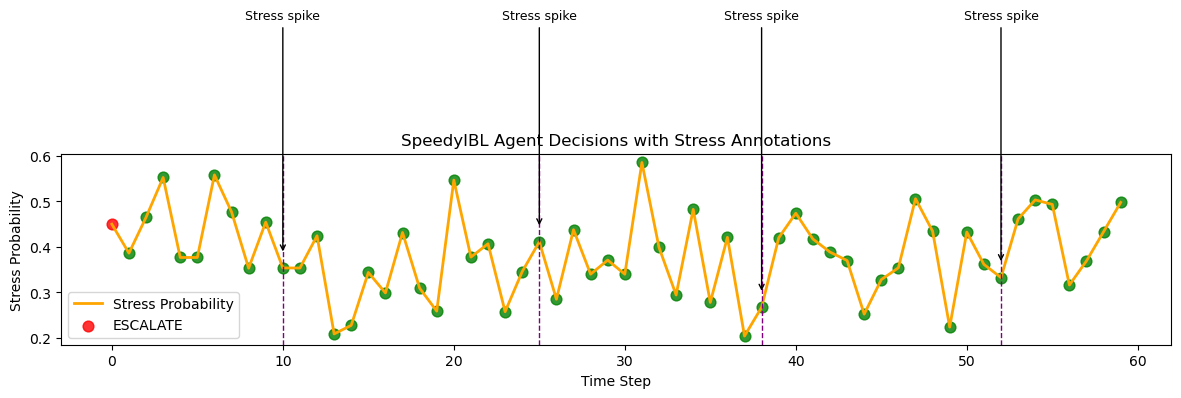

In [17]:
from speedyibl import Agent
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Simulate stress probabilities
np.random.seed(42)
n_trials = 60
stress_probs = np.clip(np.random.normal(0.4, 0.1, n_trials), 0, 1)

# Initialize SpeedyIBL agent
agent = Agent(default_utility=0.0)
actions = ['WAIT', 'MONITOR', 'ESCALATE']
action_history = []
utility_history = []

# Reward logic
def reward_function(prob, action):
    if prob > 0.6 and action == 'ESCALATE':
        return 1.0
    elif prob > 0.6 and action == 'WAIT':
        return -1.0
    elif prob < 0.4 and action == 'WAIT':
        return 0.5
    elif action == 'MONITOR':
        return 0.2
    else:
        return -0.2

# Run decision loop
for prob in stress_probs:
    choice = agent.choose(actions)
    utility = reward_function(prob, choice)
    agent.respond(utility)
    action_history.append(choice)
    utility_history.append(utility)

# Build DataFrame
df = pd.DataFrame({
    "Time": np.arange(n_trials),
    "Stress_Prob": stress_probs,
    "Action": action_history,
    "Utility": utility_history
})

# Simulate ground truth stress (e.g., from expert annotation or labels)
stress_spikes = [10, 25, 38, 52]

# Plot stress and actions
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["Time"], df["Stress_Prob"], color="orange", label="Stress Probability", linewidth=2)

colors = {"WAIT": "blue", "MONITOR": "green", "ESCALATE": "red"}
for idx, row in df.iterrows():
    ax.scatter(row["Time"], row["Stress_Prob"], color=colors[row["Action"]], s=60, label=row["Action"] if idx == 0 else "", alpha=0.8)

# Vertical lines for annotated stress events
for spike in stress_spikes:
    ax.axvline(spike, color="purple", linestyle="--", linewidth=1)
    ax.annotate("Stress spike", xy=(spike, df.loc[spike, "Stress_Prob"] + 0.03), xytext=(spike, 0.9),
                arrowprops=dict(arrowstyle="->", color="black"), fontsize=9, ha='center')

# Labels and legend
ax.set_title("SpeedyIBL Agent Decisions with Stress Annotations")
ax.set_xlabel("Time Step")
ax.set_ylabel("Stress Probability")
ax.legend()

# Inset for utility tracking

#axins = inset_axes(ax, width="30%", height="30%", loc='upper right')
#axins.plot(df["Time"], df["Utility"], color='gray', marker='o', markersize=3)
#axins.set_title("Utility Over Time", fontsize=10)
#axins.set_xlabel("Time", fontsize=8)
#axins.set_ylabel("Utility", fontsize=8)
#axins.tick_params(axis='both', labelsize=8)

plt.tight_layout()
plt.savefig("c3.png", dpi=300, bbox_inches='tight')
plt.show()


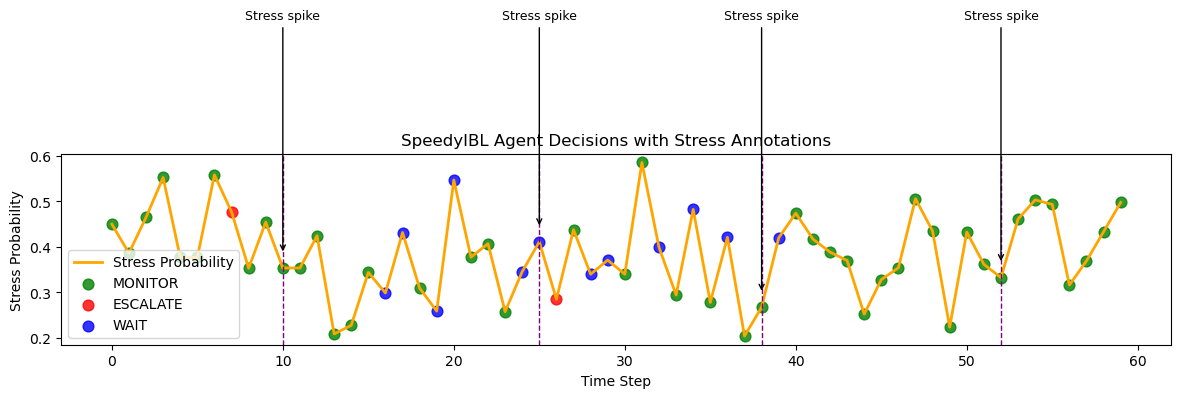

In [23]:
from speedyibl import Agent
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1️⃣ Simulate stress probabilities
np.random.seed(42)
n_trials = 60
stress_probs = np.clip(np.random.normal(0.4, 0.1, n_trials), 0, 1)

# 2️⃣ Initialize SpeedyIBL agent
agent = Agent(default_utility=0.0)
actions = ['WAIT', 'MONITOR', 'ESCALATE']
action_history = []
utility_history = []

# 3️⃣ Define reward function
def reward_function(prob, action):
    if prob > 0.55 and action == 'ESCALATE':
        return 1.0
    elif prob > 0.6 and action == 'WAIT':
        return -1.0
    elif prob < 0.35 and action == 'WAIT':
        return 0.5
    elif 0.35 <= prob <= 0.55 and action == 'MONITOR':
        return 0.3
    else:
        return -0.3


# 4️⃣ Run decision loop
for prob in stress_probs:
    choice = agent.choose(actions)
    utility = reward_function(prob, choice)
    agent.respond(utility)
    action_history.append(choice)
    utility_history.append(utility)

# 5️⃣ Build DataFrame
df = pd.DataFrame({
    "Time": np.arange(n_trials),
    "Stress_Prob": stress_probs,
    "Action": action_history,
    "Utility": utility_history
})

# 6️⃣ Simulated ground truth spikes
stress_spikes = [10, 25, 38, 52]

# 7️⃣ Plot stress and decisions
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["Time"], df["Stress_Prob"], color="orange", label="Stress Probability", linewidth=2)

# ✅ Improved legend handling
colors = {"WAIT": "blue", "MONITOR": "green", "ESCALATE": "red"}
added_labels = set()

for idx, row in df.iterrows():
    action = row["Action"]
    label = action if action not in added_labels else None
    ax.scatter(row["Time"], row["Stress_Prob"], color=colors[action], s=60, alpha=0.8, label=label)
    added_labels.add(action)

# 8️⃣ Annotate stress spikes
for spike in stress_spikes:
    ax.axvline(spike, color="purple", linestyle="--", linewidth=1)
    ax.annotate("Stress spike", xy=(spike, df.loc[spike, "Stress_Prob"] + 0.03), xytext=(spike, 0.9),
                arrowprops=dict(arrowstyle="->", color="black"), fontsize=9, ha='center')

# 9️⃣ Final formatting
ax.set_title("SpeedyIBL Agent Decisions with Stress Annotations")
ax.set_xlabel("Time Step")
ax.set_ylabel("Stress Probability")
ax.legend()
plt.tight_layout()
plt.savefig("c3_updated.png", dpi=300, bbox_inches='tight')
plt.show()
